# 0.0 Imports

In [1]:
import pandas as pd
import numpy  as np

import scipy.stats       as ss
import matplotlib.pyplot as plt
import seaborn           as sns

from matplotlib                    import gridspec

from sklearn                       import preprocessing as pp
from sklearn.metrics               import accuracy_score, recall_score, precision_score
from sklearn.model_selection       import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.svm                   import SVC
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network        import MLPClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.linear_model          import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost                       import XGBClassifier
from lightgbm                      import LGBMClassifier
from catboost                      import CatBoostClassifier

from category_encoders             import OneHotEncoder, OrdinalEncoder
from boruta                        import BorutaPy
from IPython.display               import Image

# 0.1 Helper Functions

In [2]:
plt.style.use('seaborn')

def cramer_v(x, y):
    '''This functions calculates the Cramér V, a measure of association between two nominal variables'''
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / min(kcorr - 1, rcorr - 1))

    cm = pd.crosstab(x, y).matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

# 0.2 Data Collection

In [3]:
df_raw = pd.read_csv('dataset/cardio_train.csv', sep=';')

In [4]:
df_raw.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# 1.0 Data Description

In [5]:
df1 = df_raw.drop('id', axis=1).copy()

## 1.1 Data Dimension

In [6]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 70000
Number of columns: 12


## 1.2 Data Type

In [7]:
df1.dtypes

age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.3 NA and Duplicates Check

In [8]:
df1.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [9]:
duplicates = len(df1) - len(df1.drop_duplicates())
df1.drop_duplicates(inplace=True)
print('{} duplicate records dropped'.format(duplicates))

24 duplicate records dropped


In [10]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of columns: {}".format(df1.shape[1]))

Number of rows: 69976
Number of columns: 12


## 1.4 Check Balanced Data

In [11]:
df1['cardio'].value_counts(normalize=True)

0    0.500229
1    0.499771
Name: cardio, dtype: float64

## 1.5 Descriptive Analysis

In [12]:
num_attributes = df1[['age', 'height', 'weight', 'ap_hi', 'ap_lo']]
cat_attributes = df1.drop(['age', 'height', 'weight', 'ap_hi', 'ap_lo'], axis=1).copy()

### 1.5.1 Numerical Variables

In [13]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenating
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mean', 'Median', 'Std', 'Skew', 'Kurtosis']
m

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,age,10798.0,23713.0,12915.0,19468.950126,19703.0,2467.356990,-0.307076,-0.823501
1,height,55.0,250.0,195.0,164.359152,165.0,8.211160,-0.642142,7.941495
2,weight,10.0,200.0,190.0,74.208519,72.0,14.397108,1.011633,2.585593
3,ap_hi,-150.0,16020.0,16170.0,128.820453,120.0,154.036629,85.281695,7577.487566
4,ap_lo,-70.0,11000.0,11070.0,96.636261,80.0,188.503234,32.108622,1425.428849


Some data are suspicious:

- Min height is 55 cm
- Max height is 250 cm
- Min weight is 10 kg
- Max weight is 200 kg
- Min systolic blood pressure (ap_hi) is -150 mmHg
- Max systolic blood pressure (ap_hi) is 16020 mmHg
- Min diastolic blood pressure (ap_hi) is -70 mmHg
- Max diastolic blood pressure (ap_hi) is 11000 mmHg

### 1.5.2 Categorical Variables

In [14]:
cat_attributes.dtypes

gender         int64
cholesterol    int64
gluc           int64
smoke          int64
alco           int64
active         int64
cardio         int64
dtype: object

In [15]:
cat_attributes = cat_attributes.apply(lambda x: x.astype(str))

In [16]:
cat_attributes.dtypes

gender         object
cholesterol    object
gluc           object
smoke          object
alco           object
active         object
cardio         object
dtype: object

In [17]:
cat_attributes.describe()

,gender,cholesterol,gluc,smoke,alco,active,cardio
count,69976,69976,69976,69976,69976,69976,69976
unique,2,3,3,2,2,2,2
top,1,1,1,0,0,1,0
freq,45509,52361,59455,63807,66212,56241,35004


### 1.5.3 Check Outliers

In [18]:
# Age is given in days. Let's transform it to years for better understanding and interpreting.
df1['age'] = df1['age'] / 365

<AxesSubplot:>

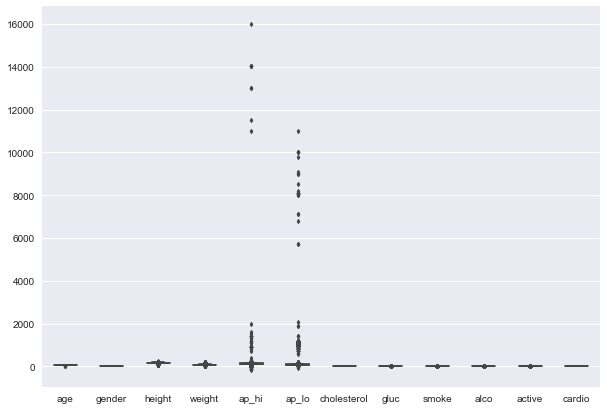

In [19]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df1, width = 0.5, fliersize = 3)

We can see relevant outliers in some features. Let's analyse **height**, **weight**, **ap_hi** and **ap_lo**.

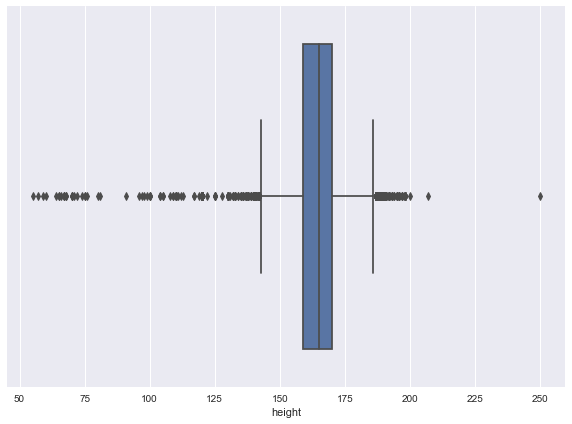

In [20]:
plt.figure(figsize=(10, 7))
sns.boxplot(data = df1, x='height');

From the above plot we can see some outliers in height feature. There is someone with **250cm** of height what obviously is a outlier and some people with less than **100cm** that we need to  take a better look as they can be children.

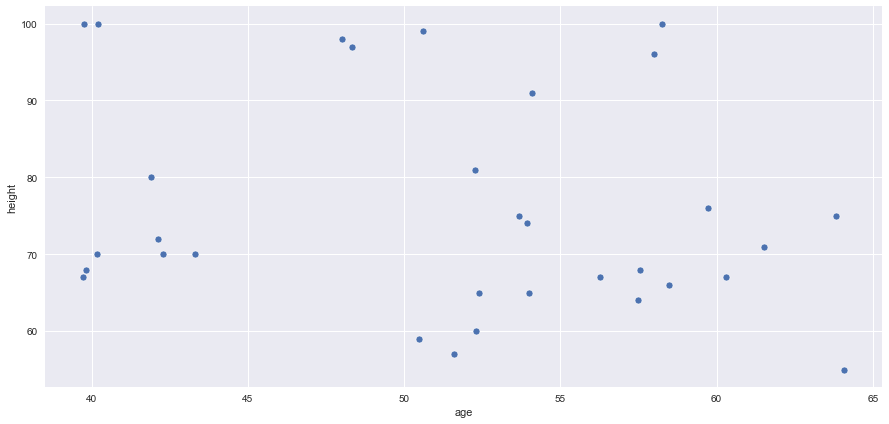

In [21]:
aux = df1[df1['height'] <= 100]

plt.figure(figsize=(15, 7))
sns.scatterplot(data=aux, x='age', y='height');

Now we can see that there is no children in our dataset. For analytical purpose we can remove these records from our data. 

In [22]:
filter_height1 = df1['height'] <= 100
df1.drop(index=list(df1[filter_height1].index), inplace=True)

filter_height2 = df1['height'] >= 250
df1.drop(index=list(df1[filter_height2].index), inplace=True)

df1.shape

(69943, 12)

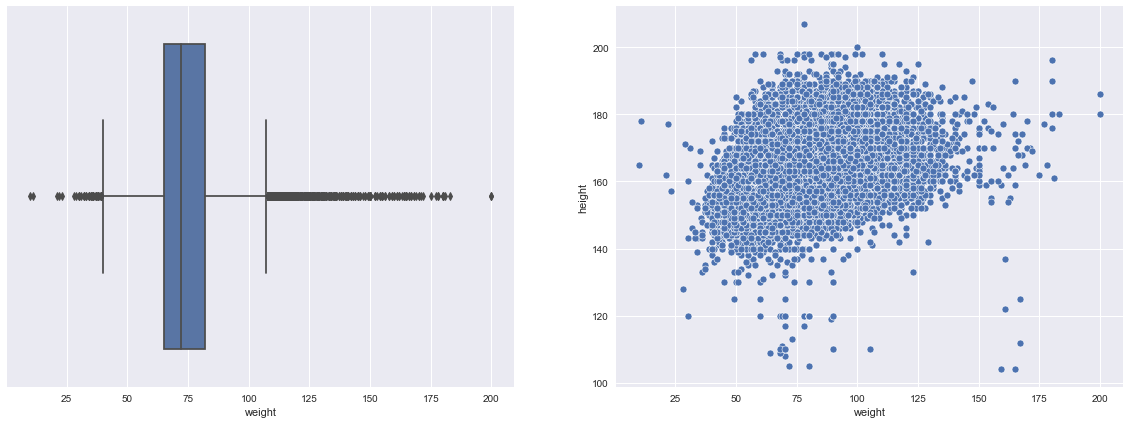

In [23]:
plt.figure(figsize=(20, 7))

plt.subplot(1,2,1)
sns.boxplot(data=df1, x='weight');

plt.subplot(1,2,2)
sns.scatterplot(data=df1, x='weight', y='height');

In this last plot we see some strange things like some people with less then 25kg and others with more than 175kg. We can still see people with more than 150kg and less than 140cm of height. We see people with more than 155cm and weighting until 35kg.

In [24]:
filter_weight1 = df1['weight'] < 25
df1.drop(index=list(df1[filter_weight1].index), inplace=True)

filter_weight2 = df1['weight'] > 175
df1.drop(index=list(df1[filter_weight2].index), inplace=True)

filter_hei_wei1 = (df1['height'] < 140) & (df1['weight'] > 150)
df1.drop(index=list(df1[filter_hei_wei1].index), inplace=True)

filter_hei_wei2 = (df1['height'] > 155) & (df1['weight']  <= 35)
df1.drop(index=list(df1[filter_hei_wei2].index), inplace=True)

df1 = df1[df1['height'] > df1['weight']]

df1.shape

(69901, 12)

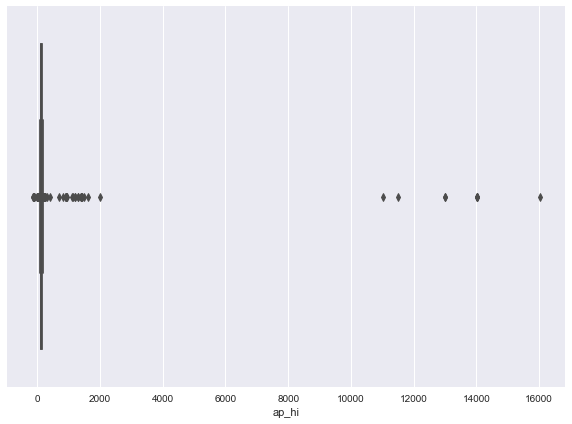

In [25]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df1, x='ap_hi');

From the above plot we can see some outliers in ap_hi feature. There are some people with more than **10000mmHg** of systolic blood pressure what obviously are outliers and others that we have to see better.

In [26]:
# Systolic quantiles.
Q1 = df1['ap_hi'].quantile(0.25)
Q3 = df1['ap_hi'].quantile(0.75)
IQR = Q3 - Q1
lower_th = Q1 - (IQR * 1.5)
upper_th = Q3 + (IQR * 1.5)
print('Systolic (ap_hi) \nQ1: {}\nQ3: {}\nlower_th: {}\nupper_th: {}\n'.format(Q1, Q3, lower_th, upper_th))

Systolic (ap_hi) 
Q1: 120.0
Q3: 140.0
lower_th: 90.0
upper_th: 170.0



It is known that Systolic blood pressure above 180mmHG can happen when the pacient is having a hypertensive crisis. So, we are going to remove all records over **200mmHG**.
Systolic blood pressure of 90mmHg is low, but we know that can happen. So let's remove all records under **70mmHG**.

In [27]:
# Systolic blood pressure bigger then 70mmHg and smaller than 200mmHg.
df1 = df1[df1['ap_hi'] < 200]
df1 = df1[df1['ap_hi'] > 70]

# Systolic blood pressure can not be smaller than diastolic blood pressure.
df1 = df1[df1['ap_hi'] > df1['ap_lo']]

df1.shape

(68472, 12)

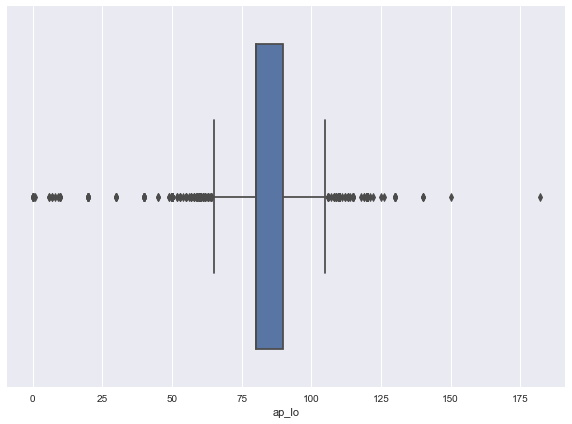

In [28]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df1, x='ap_lo');

From the above plot we can see some outliers in ap_lo feature. There are some people with more than **150mmHg** and others that have less of **25mmHg** of diastolic blood pressure what obviously are outliers.

In [29]:
# Diastolic quantiles.
Q1 = df1['ap_lo'].quantile(0.25)
Q3 = df1['ap_lo'].quantile(0.75)
IQR = Q3 - Q1
lower_th = Q1 - (IQR * 1.5)
upper_th = Q3 + (IQR * 1.5)
print('Diastolic (ap_lo) \nQ1: {}\nQ3: {}\nlower_th: {}\nupper_th: {}\n'.format(Q1, Q3, lower_th, upper_th))

Diastolic (ap_lo) 
Q1: 80.0
Q3: 90.0
lower_th: 65.0
upper_th: 105.0



It is known that Dystolic blood pressure above 120mmHG can happen when the pacient is having a hypertensive crisis. So, we are going to remove all records over **140mmHG**.
Diastolic blood pressure of 65mmHg is low, but we know that can happen. So we are going revome all records under **45mmHG**.

In [30]:
# Diastolic blood pressure bigger then 70mmHg and smaller than 140mmHg.
df1 = df1[df1['ap_lo'] < 140]
df1 = df1[df1['ap_lo'] > 45]

df1.shape

(68407, 12)

With all modifications we lost **1593** registers what represents **2.27%** of our data. We can work with **68407** records with ease.

# 2.0 Feature Engineering

In [31]:
df2 = df1.copy()

In [32]:
# height, weight
## bmi
df2['bmi'] = round(df2['weight'] / (df2['height']/100)**2, 2)

## bmi_cat
df2['bmi_cat'] = df2['bmi'].apply(lambda x: 'underweight'    if x < 18.5 else
                                            'healthy weight' if x < 25 else
                                            'overweight'     if x < 30 else
                                            'obese'          if x < 35 else
                                            'severely obese' if x < 40 else
                                            'morbidly obese')

# height
## height_bin
df2['height_bin'] = pd.cut(df2.height, bins=4, labels=['h1','h2','h3','h4'])


# weight
## weight_bin
df2['weight_bin'] = pd.cut(df2.weight, bins=4, labels=['w1','w2','w3','w4'])


# age
## age_cat
df2['age_cat'] = df2['age'].apply(lambda x: 'young adult' if x <= 35 else
                                            'middle-aged' if x <= 55 else
                                            'older adult')

# gender
## gender
df2['gender'] = df2['gender'] % 2

## gender_cat
df2['gender_cat'] = df2['gender'].map({1:'women', 0:'men'})


# ap_hi
## ap_hi_cat
df2['ap_hi_cat'] = df2['ap_hi'].apply(lambda x: 'ap_hi_1' if x < 120 else
                                                'ap_hi_2' if x < 129 else
                                                'ap_hi_3' if x < 139 else
                                                'ap_hi_4' if x < 180 else
                                                'ap_hi_5')


# ap_lo
## ap_lo_cat
df2['ap_lo_cat'] = df2['ap_lo'].apply(lambda x: 'ap_lo_1' if x <  80 else
                                                'ap_lo_2' if x <  90 else
                                                'ap_lo_3' if x < 120 else
                                                'ap_lo_4')


# ap_hi, ap_lo
## pressure_stage
df2['pressure_stage'] = np.nan
df2.loc[(df2['ap_hi_cat'] == 'ap_hi_1')&(df2['ap_lo_cat'] == 'ap_lo_1'), 'pressure_stage'] = 'normal'
df2.loc[(df2['ap_hi_cat'] == 'ap_hi_2')&(df2['ap_lo_cat'] == 'ap_lo_1'), 'pressure_stage'] = 'elevated'
df2.loc[(df2['ap_hi_cat'] == 'ap_hi_3')|(df2['ap_lo_cat'] == 'ap_lo_2'), 'pressure_stage'] = 'hypertension - stage 1'
df2.loc[(df2['ap_hi_cat'] == 'ap_hi_4')|(df2['ap_lo_cat'] == 'ap_lo_3'), 'pressure_stage'] = 'hypertension - stage 2'
df2.loc[(df2['ap_hi_cat'] == 'ap_hi_5')|(df2['ap_lo_cat'] == 'ap_lo_4'), 'pressure_stage'] = 'hypertensive crisis'



# cholesterol
## cholesterol_cat
df2['cholesterol_cat'] = df2['cholesterol'].apply(lambda x: 'normal'       if x == 1 else
                                                            'above normal' if x == 2 else
                                                            'well above normal')


# gluc
## gluc_cat
df2['gluc_cat'] = df2['gluc'].apply(lambda x: 'normal'       if x == 1 else
                                              'above normal' if x == 2 else
                                              'well above normal')

In [33]:
df2.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,...,bmi_cat,height_bin,weight_bin,age_cat,gender_cat,ap_hi_cat,ap_lo_cat,pressure_stage,cholesterol_cat,gluc_cat
0,50.391781,0,168,62.0,110,80,1,1,0,0,...,healthy weight,h3,w1,middle-aged,men,ap_hi_1,ap_lo_2,hypertension - stage 1,normal,normal
1,55.419178,1,156,85.0,140,90,3,1,0,0,...,obese,h2,w2,older adult,women,ap_hi_4,ap_lo_3,hypertension - stage 2,well above normal,normal
2,51.663014,1,165,64.0,130,70,3,1,0,0,...,healthy weight,h3,w2,middle-aged,women,ap_hi_3,ap_lo_1,hypertension - stage 1,well above normal,normal
3,48.282192,0,169,82.0,150,100,1,1,0,0,...,overweight,h3,w2,middle-aged,men,ap_hi_4,ap_lo_3,hypertension - stage 2,normal,normal
4,47.873973,1,156,56.0,100,60,1,1,0,0,...,healthy weight,h2,w1,middle-aged,women,ap_hi_1,ap_lo_1,normal,normal,normal


# 3.0 Exploratory Data Analysis (EDA)

In [34]:
df3 = df2.copy()

## 3.1 Hypothesis Mind Map

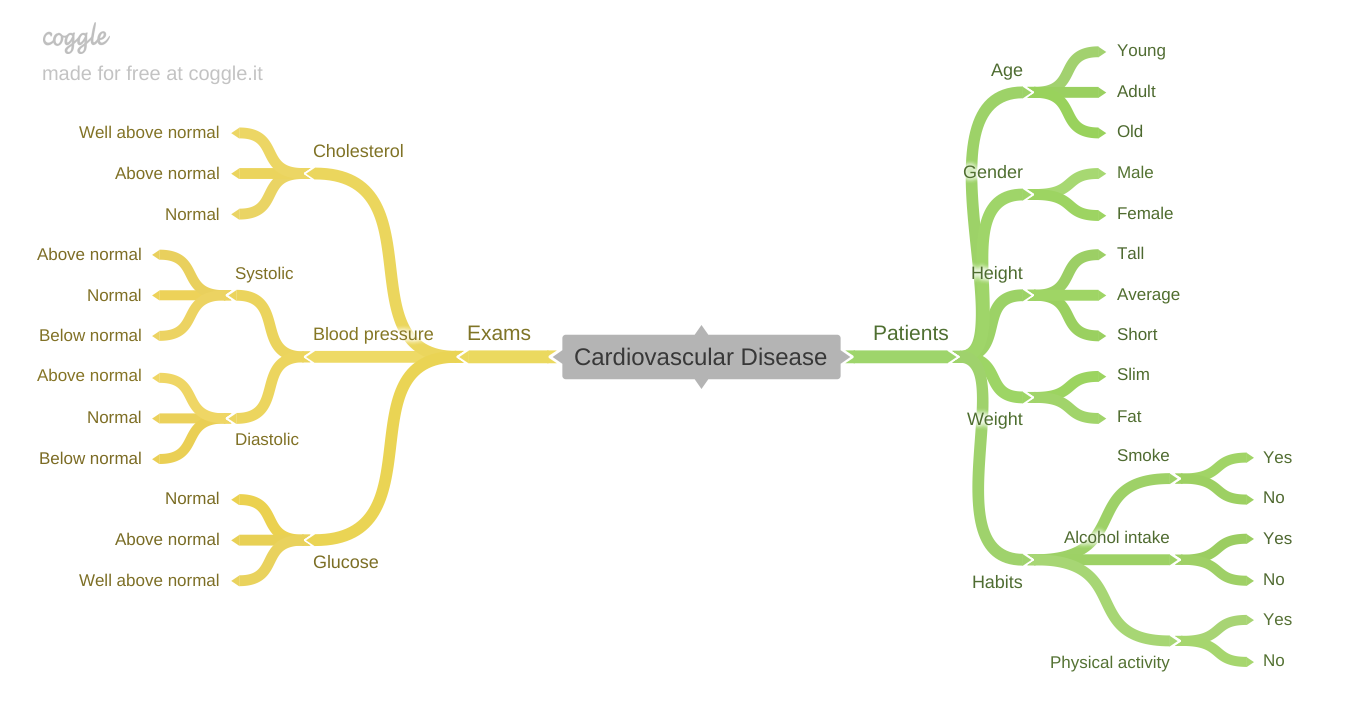

In [35]:
Image('images/Cardiovascular_Disease_MindMapHypothesis_v2.png')

## 3.2 Hypothesis List

### 3.2.1 Exams

**H01.** Patients with well above normal glucose should be more likely to have heart disease.

**H02.** Patients with well above normal cholesterol should be more likely to have heart disease.

**H03.** Patients with normal systolic blood pressure should be more likely to not have heart disease.

**H04.** Patients with normal diastolic blood pressure should be more likely to not have heart disease.

### 3.2.2 Patients

**H05.** Older patients should be more likely to have heart disease.

**H06.** Patients who are male should be more likely to have heart disease.

**H07.** Taller patients should be more likely to have heart disease.

**H08.** Fatter patients should be more likely to have heart disease.

**H09.** Patient who smokes should be more likely to have heart disease.

**H10.** Patient who drinks alcohol should be more likely to have heart disease.

**H11.** Patient who does not practice exercise should be more likely to have heart disease.

## 3.2 Univariate Analysis

### 3.2.1 Response Variable

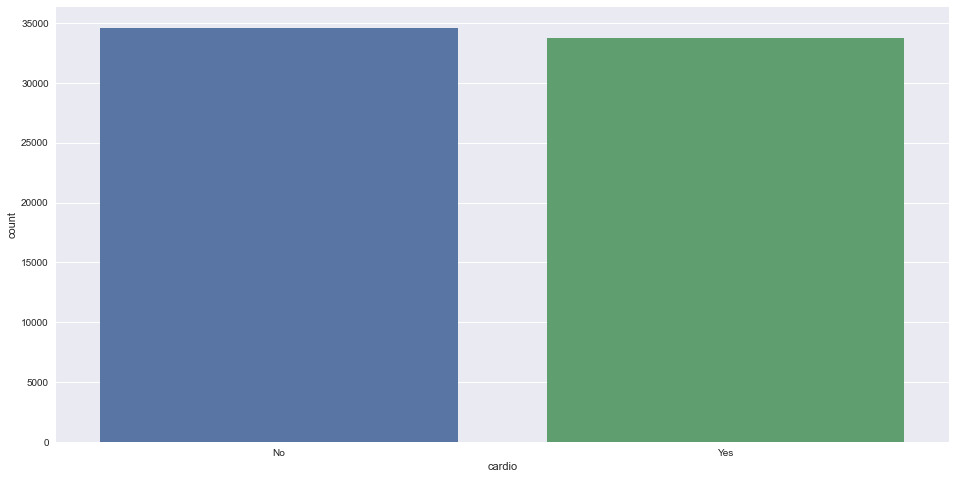

In [36]:
plt.figure(figsize=(16,8))
sns.countplot(x=df3['cardio'])
plt.xticks(ticks=[0, 1], labels=['No', 'Yes']);

### 3.2.2 Numerical Variable

In [37]:
num_attributes = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi']

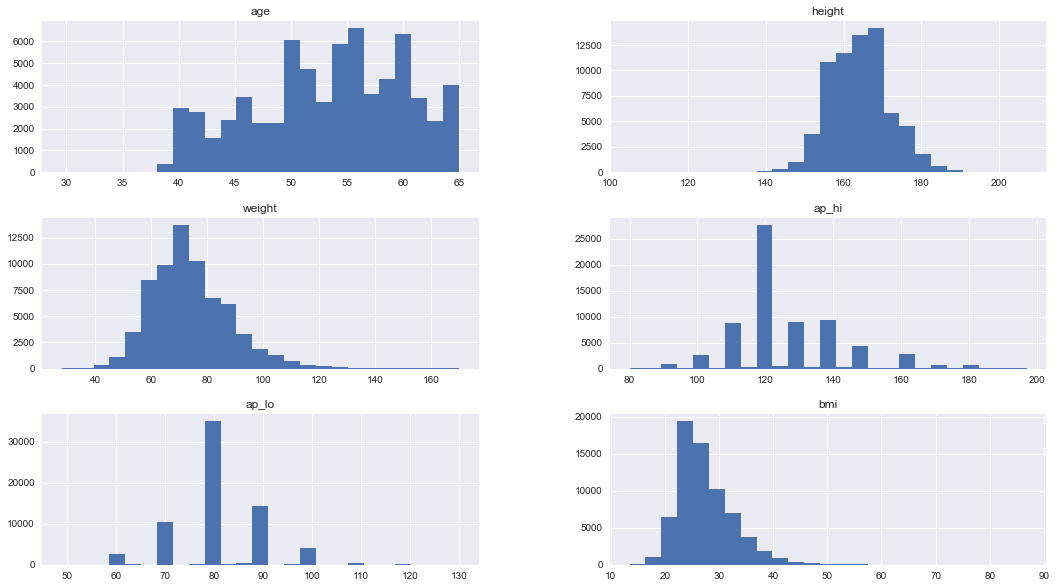

In [38]:
df3[num_attributes].hist(bins=25, figsize=(18,10));

### 3.2.3 Categorical Variable

In [39]:
cat_attributes = df3[['gender_cat', 'cholesterol_cat', 'gluc_cat', 'smoke', 'alco', 'active', 'age_cat', 'height_bin', 'weight_bin', 'bmi_cat', 'ap_hi_cat', 'ap_lo_cat', 'pressure_stage']].copy()

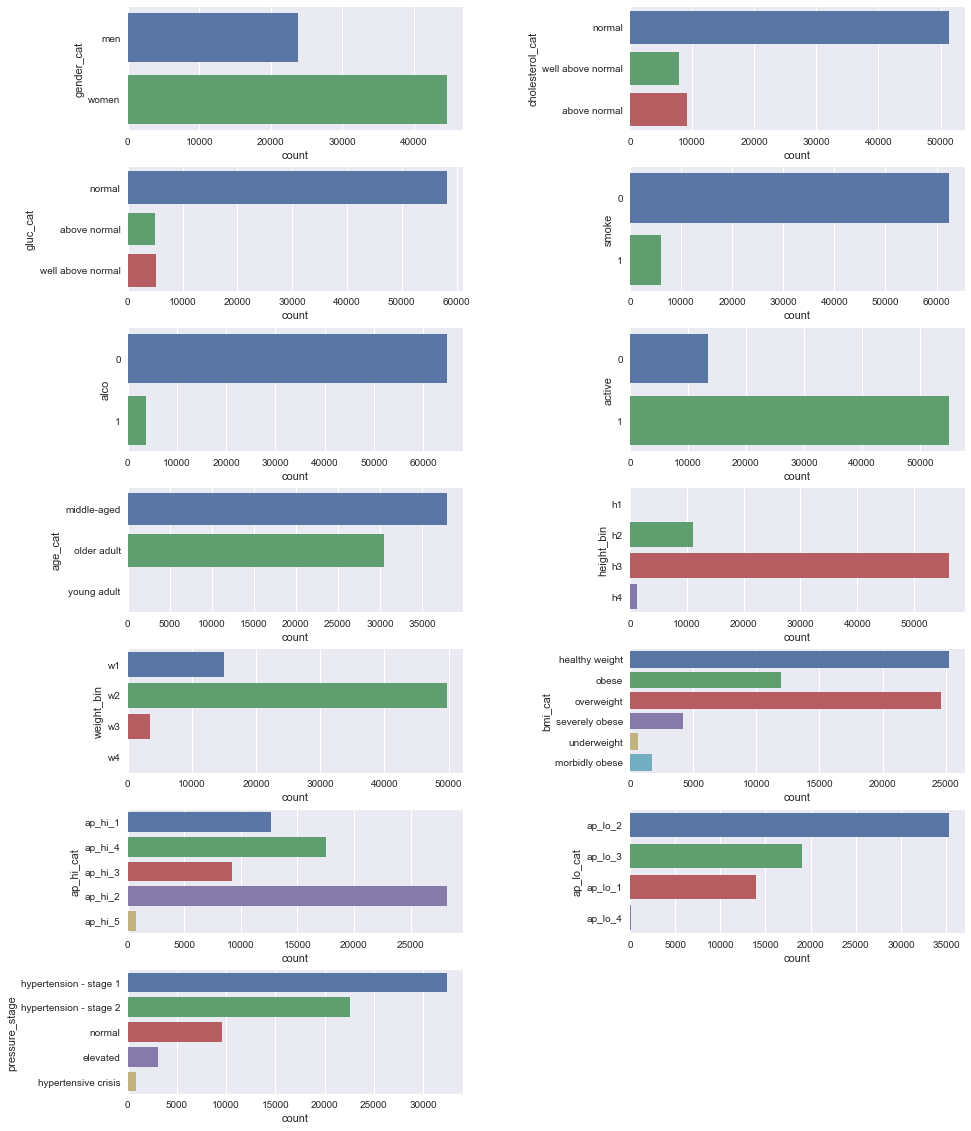

In [40]:
plt.figure(figsize=(15,20))

# sets the inital plot position
n = 1

for att in cat_attributes:
    plt.subplot(7,2,n)
    sns.countplot(y=cat_attributes[att])
    n += 1
    
# space between subplots  
plt.subplots_adjust(hspace=0.3)
plt.subplots_adjust(wspace=0.5)

## 3.2 Bivariate Analysis

### **H01.** Patients with well above normal glucose should be more likely to have heart disease.
**True.** Patients with well above normal glucose are more likely to have heart disease.

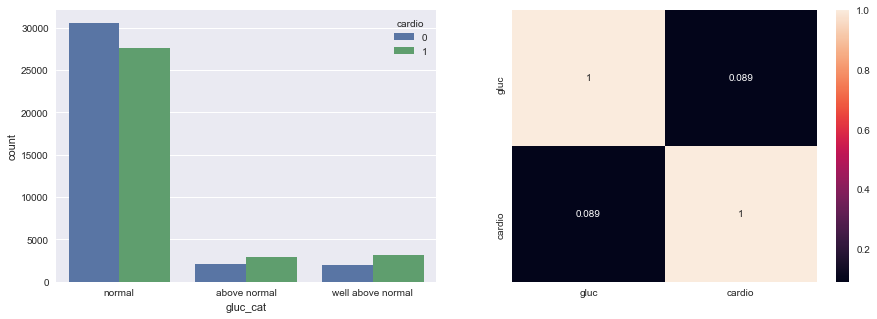

In [41]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df3, x='gluc_cat', hue='cardio')

plt.subplot(1,2,2)
sns.heatmap(df3[['gluc', 'cardio']].corr('pearson'), annot=True);

In [42]:
print('Normal:\n{}\n'.format(df3[df3['gluc_cat'] == 'normal']['cardio'].value_counts(normalize=True).sort_index()))
print('Above Normal:\n{}\n'.format(df3[df3['gluc_cat'] == 'above normal']['cardio'].value_counts(normalize=True).sort_index()))
print('Well Above Normal:\n{}'.format(df3[df3['gluc_cat'] == 'well above normal']['cardio'].value_counts(normalize=True).sort_index()))

Normal:
0    0.524955
1    0.475045
Name: cardio, dtype: float64

Above Normal:
0    0.413718
1    0.586282
Name: cardio, dtype: float64

Well Above Normal:
0    0.383593
1    0.616407
Name: cardio, dtype: float64


### **H02.** Patients with well above normal cholesterol should be more likely to have heart disease.
**True.** Patients with well above normal cholesterol are more likely to have heart disease.

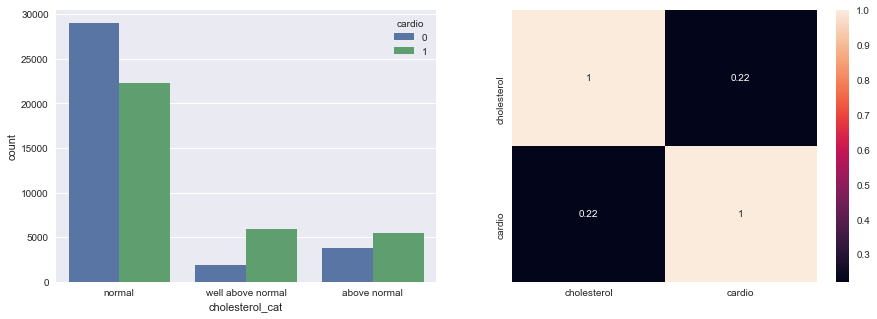

In [43]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df3, x='cholesterol_cat', hue='cardio')

plt.subplot(1,2,2)
sns.heatmap(df3[['cholesterol','cardio']].corr('pearson'), annot=True);

In [44]:
print('Normal:\n{}\n'.format(df3[df3['cholesterol_cat'] == 'normal']['cardio'].value_counts(normalize=True).sort_index()))
print('Above Normal:\n{}\n'.format(df3[df3['cholesterol_cat'] == 'above normal']['cardio'].value_counts(normalize=True).sort_index()))
print('Well Above Normal:\n{}'.format(df3[df3['cholesterol_cat'] == 'well above normal']['cardio'].value_counts(normalize=True).sort_index()))

Normal:
0    0.565145
1    0.434855
Name: cardio, dtype: float64

Above Normal:
0    0.404692
1    0.595308
Name: cardio, dtype: float64

Well Above Normal:
0    0.23818
1    0.76182
Name: cardio, dtype: float64


### **H03.** Patients with normal systolic blood pressure should be more likely to not have heart disease.
**True.** Patients with normal systolic blood pressure are healthier and have less cardio disease.

**Legend**
- ap_hi_1 = Normal
- ap_hi_2 = Elevated
- ap_hi_3 = Hypertension (stage 1)
- ap_hi_4 = Hypertension (stage 2)
- ap_hi_5 = Hypertensive crisis

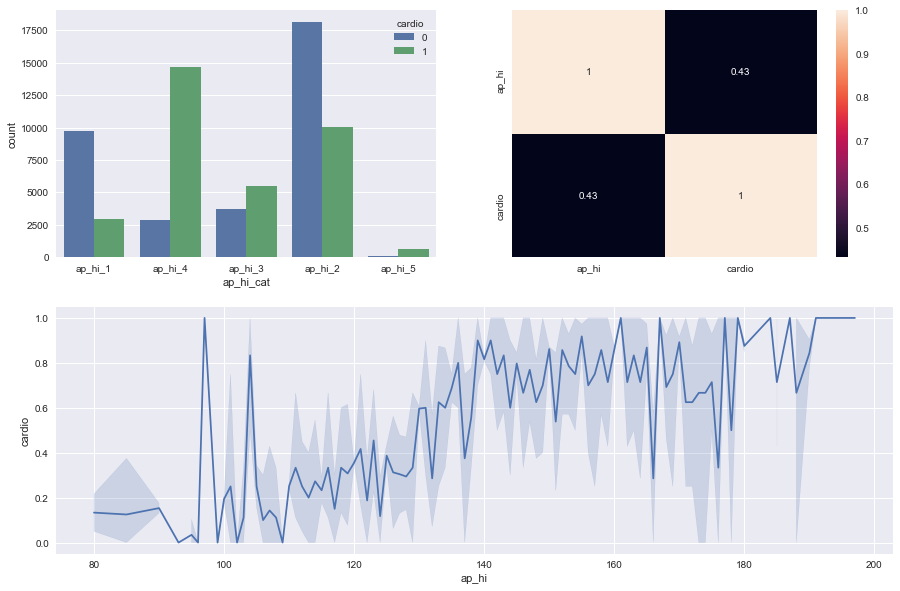

In [45]:
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(2,2)

plt.subplot(grid[0,0])
sns.countplot(data=df3, x='ap_hi_cat', hue='cardio')
plt.subplot(grid[0,1])
sns.heatmap(df3[['ap_hi','cardio']].corr('pearson'), annot=True)
plt.subplot(grid[1,:])
sns.lineplot(data=df3, x='ap_hi', y='cardio', estimator='mean');

In [46]:
print('Normal:\n{}\n'.format(df3[df3['ap_hi_cat'] == 'ap_hi_1']['cardio'].value_counts(normalize=True).sort_index()))
print('Elevated:\n{}'.format(df3[df3['ap_hi_cat'] == 'ap_hi_2']['cardio'].value_counts(normalize=True).sort_index()))

Normal:
0    0.769455
1    0.230545
Name: cardio, dtype: float64

Elevated:
0    0.643952
1    0.356048
Name: cardio, dtype: float64


### **H04.** Patients with normal diastolic blood pressure should be more likely to not have heart disease.
**True.** Patients with normal diastolic blood pressure are healthier and have less cardio disease.

**Legend**
- ap_lo_1 = Normal / Elevated
- ap_lo_2 = Hypertension (stage 1)
- ap_lo_3 = Hypertension (stage 2)
- ap_hi_4 = Hypertensive crisis

<AxesSubplot:>

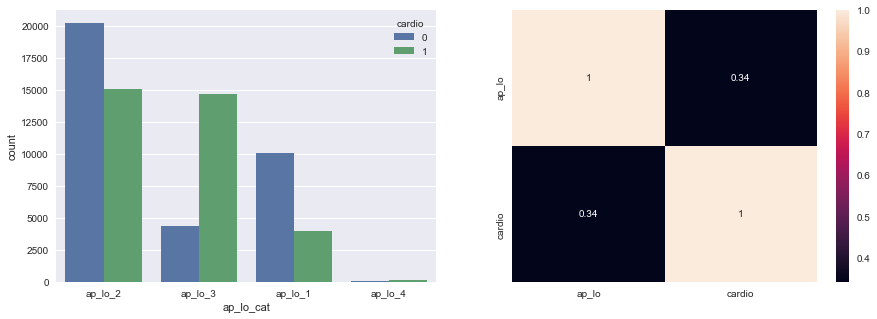

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df3, x='ap_lo_cat', hue='cardio')
plt.subplot(1,2,2)
sns.heatmap(df3[['ap_lo','cardio']].corr('pearson'), annot=True)

In [48]:
print('Normal/Elevated:\n{}\n'.format(df3[df3['ap_lo_cat'] == 'ap_lo_1']['cardio'].value_counts(normalize=True)))
print('Hypertension (Stage 1):\n{}'.format(df3[df3['ap_lo_cat'] == 'ap_lo_2']['cardio'].value_counts(normalize=True)))

Normal/Elevated:
0    0.716881
1    0.283119
Name: cardio, dtype: float64

Hypertension (Stage 1):
0    0.572821
1    0.427179
Name: cardio, dtype: float64


### **H05.** Older patients should be more likely to have heart disease.
**True.** Older patients are more likely to have heart disease.

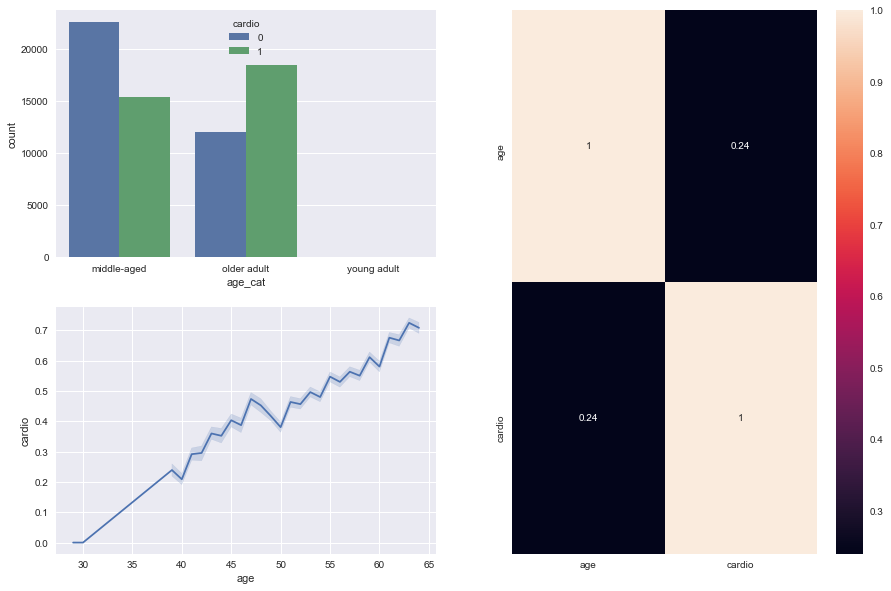

In [49]:
plt.figure(figsize=(15,10))
plt.subplot(grid[0,0])
sns.countplot(data=df3, x='age_cat', hue='cardio')
plt.subplot(grid[1,0])
sns.lineplot(data=df3, x=df3['age'].astype('int64'), y='cardio')
plt.subplot(grid[:,1])
sns.heatmap(df3[['age','cardio']].corr('pearson'), annot=True);

In [50]:
print('Young adult:\n{}\n'.format(df3[df3['age_cat'] == 'young adult']['cardio'].value_counts(normalize=True).sort_index()))
print('Middle-aged:\n{}\n'.format(df3[df3['age_cat'] == 'middle-aged']['cardio'].value_counts(normalize=True).sort_index()))
print('Older adult:\n{}\n'.format(df3[df3['age_cat'] == 'older adult']['cardio'].value_counts(normalize=True).sort_index()))

Young adult:
0    1.0
Name: cardio, dtype: float64

Middle-aged:
0    0.594995
1    0.405005
Name: cardio, dtype: float64

Older adult:
0    0.395308
1    0.604692
Name: cardio, dtype: float64



### **H06.** Male patients should be more likely to have heart disease.
**True.** Men are more likely to have heart disease.

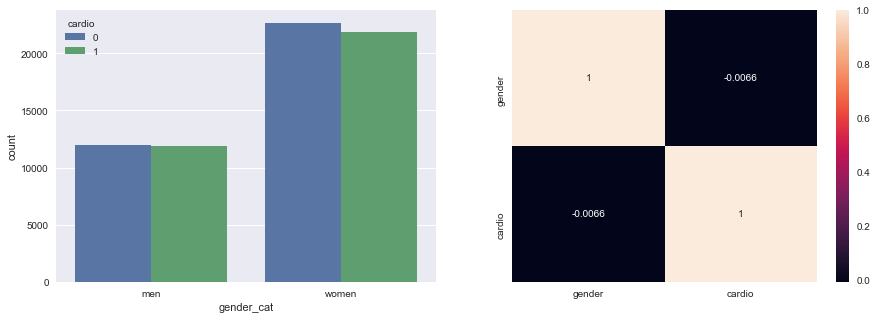

In [51]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df3, x='gender_cat', hue='cardio')
plt.subplot(1,2,2)
sns.heatmap(df3[['gender','cardio']].corr('pearson'), annot=True);

In [52]:
print("Men:\n{}\n".format(df3[df3['gender_cat'] == 'men']['cardio'].value_counts(normalize=True).sort_index()))
print("Women:\n{}\n".format(df3[df3['gender_cat'] == 'women']['cardio'].value_counts(normalize=True).sort_index()))

Men:
0    0.501531
1    0.498469
Name: cardio, dtype: float64

Women:
0    0.508458
1    0.491542
Name: cardio, dtype: float64



### **H07.** Taller patients should be more likely to have heart disease.
**False.** Taller patients do not have more heart disease.

<AxesSubplot:>

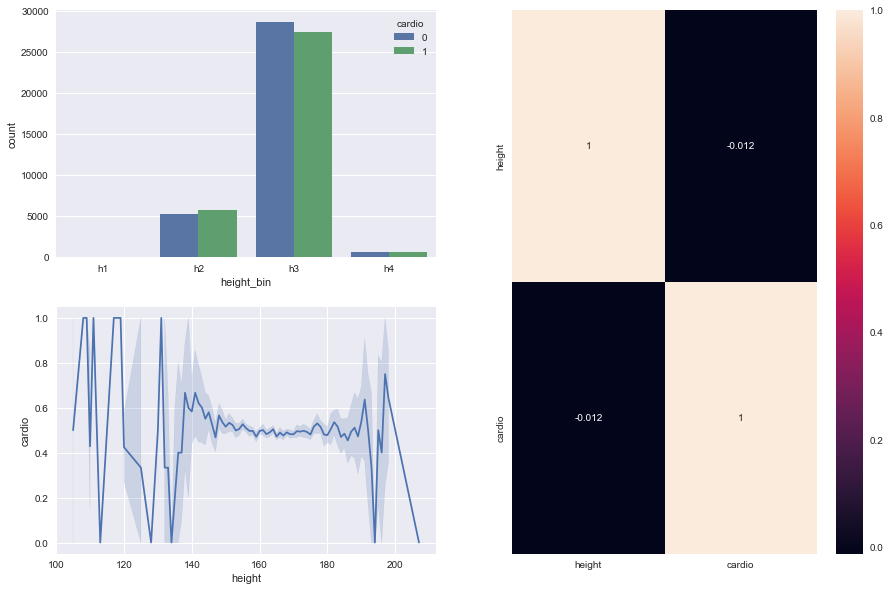

In [53]:
plt.figure(figsize=(15,10))
plt.subplot(grid[0,0])
sns.countplot(data=df3, x='height_bin', hue='cardio')
plt.subplot(grid[1,0])
sns.lineplot(data=df3, x='height', y='cardio', estimator='mean')
plt.subplot(grid[:,1])
sns.heatmap(df3[['height','cardio']].corr('pearson'), annot=True)

In [54]:
print('H1:\n{}\n'.format(df3[df3['height_bin'] == 'h1']['cardio'].value_counts(normalize=True).sort_index()))
print('H2:\n{}\n'.format(df3[df3['height_bin'] == 'h2']['cardio'].value_counts(normalize=True).sort_index()))
print('H3:\n{}\n'.format(df3[df3['height_bin'] == 'h3']['cardio'].value_counts(normalize=True).sort_index()))
print('H4:\n{}\n'.format(df3[df3['height_bin'] == 'h4']['cardio'].value_counts(normalize=True).sort_index()))

H1:
0    0.515152
1    0.484848
Name: cardio, dtype: float64

H2:
0    0.482336
1    0.517664
Name: cardio, dtype: float64

H3:
0    0.510878
1    0.489122
Name: cardio, dtype: float64

H4:
0    0.497095
1    0.502905
Name: cardio, dtype: float64



<AxesSubplot:xlabel='height', ylabel='cardio'>

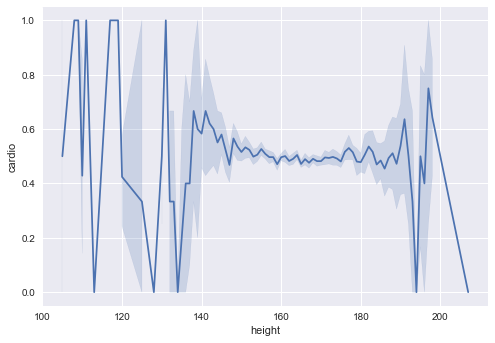

In [55]:
sns.lineplot(data=df3, x='height', y='cardio')

### **H08.** Fatter patients should be more likely to have heart disease.
**True.** Fatter patients have more heart disease.

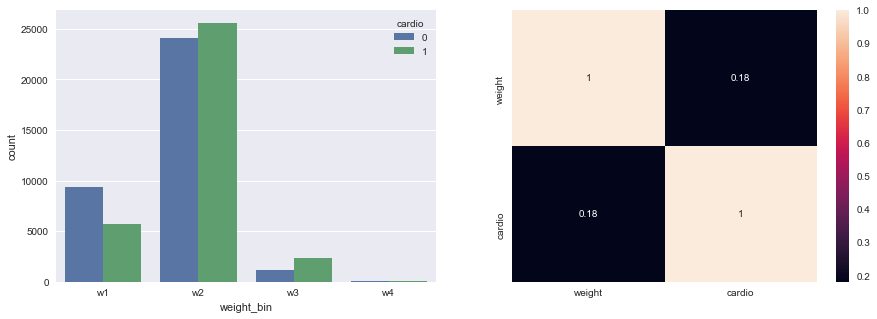

In [56]:
plt.figure(figsize=(15,5))
plt.subplot(grid[:,0])
sns.countplot(data=df3, x='weight_bin', hue='cardio')
plt.subplot(grid[:,1])
sns.heatmap(df3[['weight','cardio']].corr('pearson'), annot=True);

In [57]:
print('W1:\n{}\n'.format(df3[df3['weight_bin'] == 'w1']['cardio'].value_counts(normalize=True).sort_index()))
print('W2:\n{}\n'.format(df3[df3['weight_bin'] == 'w2']['cardio'].value_counts(normalize=True).sort_index()))
print('W3:\n{}\n'.format(df3[df3['weight_bin'] == 'w3']['cardio'].value_counts(normalize=True).sort_index()))
print('W4:\n{}\n'.format(df3[df3['weight_bin'] == 'w4']['cardio'].value_counts(normalize=True).sort_index()))

W1:
0    0.620681
1    0.379319
Name: cardio, dtype: float64

W2:
0    0.485037
1    0.514963
Name: cardio, dtype: float64

W3:
0    0.320386
1    0.679614
Name: cardio, dtype: float64

W4:
0    0.245614
1    0.754386
Name: cardio, dtype: float64



### **H09.** Patients who smokes should be more likely to have heart disease.
**False.** Patients who smokes have less heart diseases.

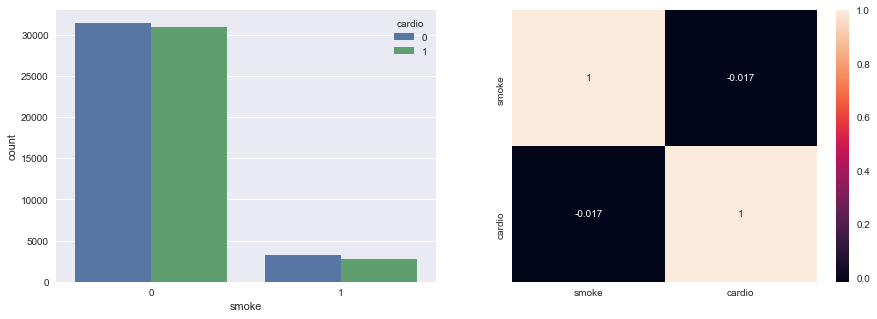

In [58]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df3, x='smoke', hue='cardio')
plt.subplot(1,2,2)
sns.heatmap(df3[['smoke','cardio']].corr('pearson'), annot=True);

In [59]:
print('No:\n{}\n'.format(df3[df3['smoke'] == 0]['cardio'].value_counts(normalize=True).sort_index()))
print('Yes:\n{}\n'.format(df3[df3['smoke'] == 1]['cardio'].value_counts(normalize=True).sort_index()))

No:
0    0.503462
1    0.496538
Name: cardio, dtype: float64

Yes:
0    0.532878
1    0.467122
Name: cardio, dtype: float64



### **H10.** Patient who drinks alcohol should be more likely to have heart disease.
**False.** Patients who drinks have less heart disease.

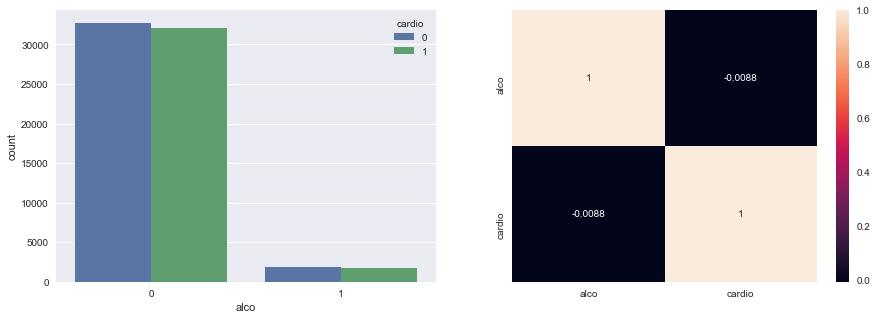

In [60]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df3, x='alco', hue='cardio')
plt.subplot(1,2,2)
sns.heatmap(df3[['alco','cardio']].corr('pearson'), annot=True);

In [61]:
print('No:\n{}\n'.format(df3[df3['alco'] == 0]['cardio'].value_counts(normalize=True).sort_index()))
print('Yes:\n{}\n'.format(df3[df3['alco'] == 1]['cardio'].value_counts(normalize=True).sort_index()))

No:
0    0.505002
1    0.494998
Name: cardio, dtype: float64

Yes:
0    0.524595
1    0.475405
Name: cardio, dtype: float64



### **H11.** Patient who does not practice exercise should be more likely to have heart disease.
**True.** Patients who does not exercise have more heart disease.

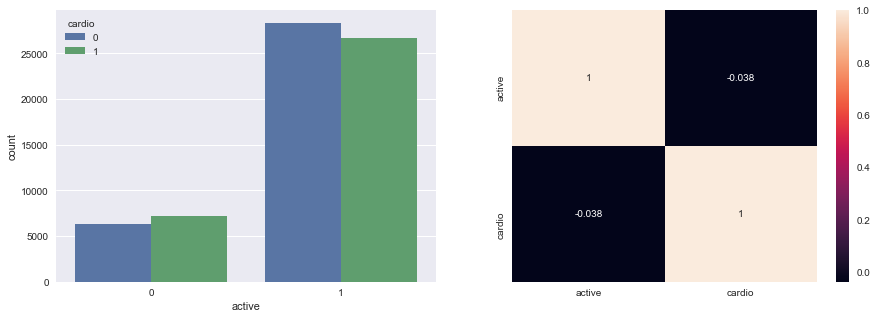

In [62]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df3, x='active', hue='cardio')
plt.subplot(1,2,2)
sns.heatmap(df3[['active','cardio']].corr('pearson'), annot=True);

In [63]:
print('No:\n{}\n'.format(df3[df3['active'] == 0]['cardio'].value_counts(normalize=True).sort_index()))
print('Yes:\n{}\n'.format(df3[df3['active'] == 1]['cardio'].value_counts(normalize=True).sort_index()))

No:
0    0.467886
1    0.532114
Name: cardio, dtype: float64

Yes:
0    0.515385
1    0.484615
Name: cardio, dtype: float64



## 3.3 Multivariate Analysis

### 3.3.1 Numerical Attributes

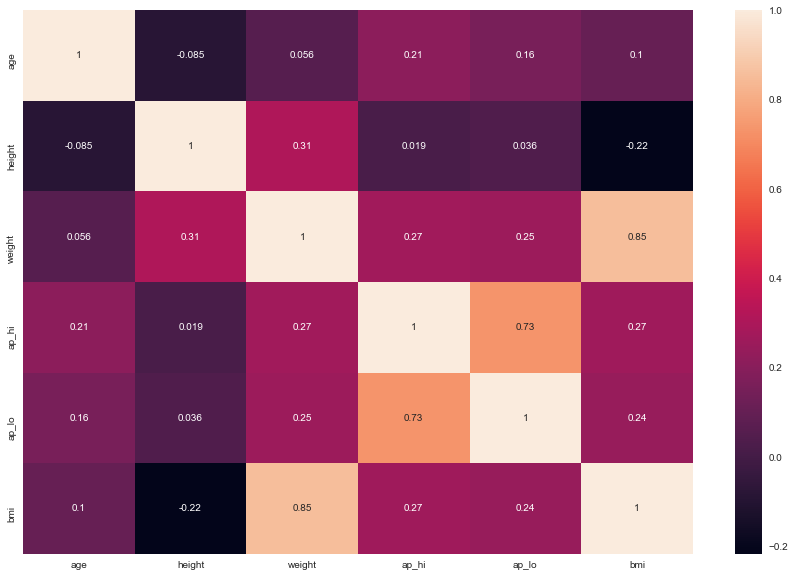

In [64]:
correlation = df3[num_attributes].corr(method='pearson')

plt.figure(figsize=(15,10))
sns.heatmap(correlation, annot=True);

- We have to take a look in BMI/Weight with **85%** of correlation. It can cause overfitting in the machine learning model, we can exclude one of the features.
- We have to take a look in ap_hi/ap_lo with **73%** of correlation. It can cause overfitting in the machine learning model, we can exclude one of the features.


### 3.3.2 Categorical Attributes

In [65]:
cat_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_list)):
    corr_list = []
    for j in range(len(cat_list)):
        ref = cat_list[i]
        feat = cat_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append
        corr_list.append(corr)
    
    corr_dict[ref] = corr_list

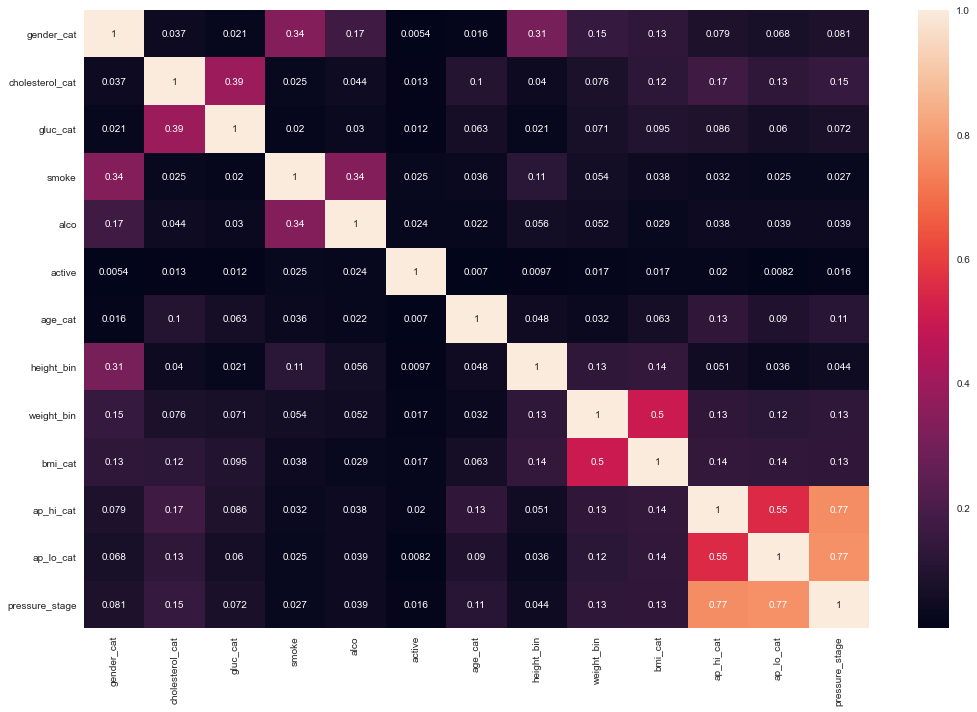

In [66]:
cat_corr = pd.DataFrame(corr_dict)
cat_corr = cat_corr.set_index(cat_corr.columns)

plt.subplots(figsize = ( 15,10))
sns.heatmap(cat_corr, annot=True)
plt.tight_layout();

- We have to take a look in pressure_stage/ap_hi_cat with **77%** of correlation. It can cause overfitting in the machine learning model, we can exclude one of the features.
- We have to take a look in pressure_stage/ap_lo_cat with **77%** of correlation. It can cause overfitting in the machine learning model, we can exclude one of the features.


# 4.0 Data Preparation

In [67]:
df4 = df3.copy()

## 4.1 Rescaling

In [68]:
#ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [69]:
# height
df4['height'] = rs.fit_transform(df4[['height']].values)

# weight
df4['weight'] = rs.fit_transform(df4[['weight']].values)

# ap_hi
df4['ap_hi'] = rs.fit_transform(df4[['ap_hi']].values)

# ap_lo
df4['ap_lo'] = rs.fit_transform(df4[['ap_lo']].values)

# age_year
df4['age'] = mms.fit_transform(df4[['age']].values)

# bmi
df4['bmi'] = rs.fit_transform(df4[['bmi']].values)

## 4.2 Encoding

In [70]:
ohe = OneHotEncoder(cols=['age_cat','height_bin','weight_bin'])
df4 = ohe.fit_transform(df4)

oe_mapping = [{'col':'bmi_cat', 'mapping':{'healthy weight':0, 'underweight':1, 'overweight':2, 'obese':3, 'severely obese':4, 'morbidly obese':5}},
             {'col':'ap_hi_cat', 'mapping':{'ap_hi_1':0, 'ap_hi_2':1, 'ap_hi_3':2, 'ap_hi_4':3, 'ap_hi_5':4}},
             {'col':'ap_lo_cat', 'mapping':{'ap_lo_1':0, 'ap_lo_2':1, 'ap_lo_3':2, 'ap_lo_4':3}},
             {'col':'pressure_stage', 'mapping':{'normal':0, 'elevated':1, 'hypertension - stage 1':2, 'hypertension - stage 2':3, 'hypertensive crisis':4}}]
oe = OrdinalEncoder(cols=['bmi_cat','ap_hi_cat','ap_lo_cat','pressure_stage'], mapping=oe_mapping)
df4 = oe.fit_transform(df4)

d:\anaconda3\envs\cardio_catch_disease\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
d:\anaconda3\envs\cardio_catch_disease\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


# 5.0 Feature Selection

In [71]:
df5 = df4.copy()

## 5.1 Filtering Columns

In [72]:
df4.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi', 'bmi_cat',
       'height_bin_1', 'height_bin_2', 'height_bin_3', 'height_bin_4',
       'weight_bin_1', 'weight_bin_2', 'weight_bin_3', 'weight_bin_4',
       'age_cat_1', 'age_cat_2', 'age_cat_3', 'gender_cat', 'ap_hi_cat',
       'ap_lo_cat', 'pressure_stage', 'cholesterol_cat', 'gluc_cat'],
      dtype='object')

In [73]:
delete_cols = ['gender_cat', 'cholesterol_cat', 'gluc_cat']
df5 = df5.drop(delete_cols, axis=1)

In [74]:
df5.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio', 'bmi', 'bmi_cat',
       'height_bin_1', 'height_bin_2', 'height_bin_3', 'height_bin_4',
       'weight_bin_1', 'weight_bin_2', 'weight_bin_3', 'weight_bin_4',
       'age_cat_1', 'age_cat_2', 'age_cat_3', 'ap_hi_cat', 'ap_lo_cat',
       'pressure_stage'],
      dtype='object')

## 5.2 Split Data into Training and Test

In [75]:
X = df5.drop('cardio', axis=1).copy()
y = df5['cardio'].copy()

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 5.3 Feature Selection

In [77]:
### training and test dataset for Boruta
#X_boruta = X_train.values
#y_boruta = y_train.values.ravel()
#
### define RandomForestClassifier
#gb = GradientBoostingClassifier()
#
### define boruta
#boruta = BorutaPy(gb, n_estimators='auto', verbose=2, random_state=42).fit(X_boruta, y_boruta)

In [78]:
#cols_selected = boruta.support_.tolist()
#
### best features
#cols_selected_boruta = X_train.iloc[:, cols_selected]
#
### not selected boruta
#cols_not_selected_boruta = np.setdiff1d(X_train.columns, cols_selected_boruta)

In [79]:
#x_train = X_train.iloc[:, cols_selected]
#x_test = X_test.iloc[:, cols_selected]

Boruta did not give us a good feature selection, so lets use RandomForest to select the features.

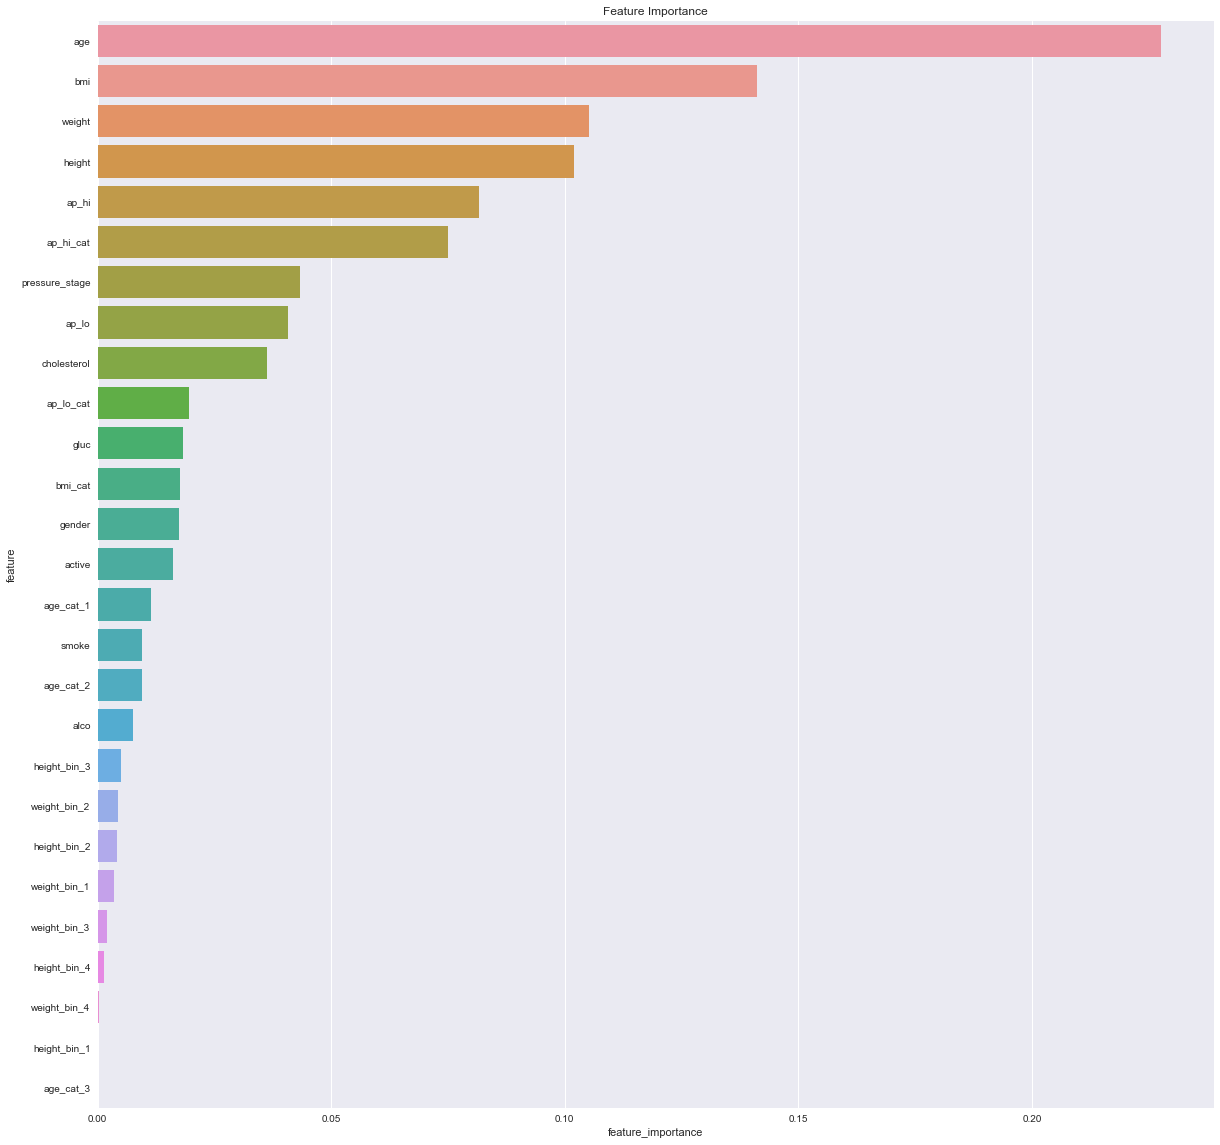

In [80]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

feature_imp = pd.DataFrame({'feature': X_train.columns,
                            'feature_importance': rf.feature_importances_}).sort_values('feature_importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(20,20));
sns.barplot(x='feature_importance', y='feature', data=feature_imp, orient='h').set_title('Feature Importance');

In [81]:
cols_selected = feature_imp[:14]
cols_list = cols_selected['feature'].to_list()
cols_list

['age',
 'bmi',
 'weight',
 'height',
 'ap_hi',
 'ap_hi_cat',
 'pressure_stage',
 'ap_lo',
 'cholesterol',
 'ap_lo_cat',
 'gluc',
 'bmi_cat',
 'gender',
 'active']

In [82]:
x_train = X_train[cols_list]
x_test = X_test[cols_list]

# 6.0 Machine Learning Modeling

## 6.1 Baseline Model

The baseline for comparison is the actual precision reached by the specialists which is between 55% and 65%.

## 6.2 Other Models

In [83]:
random_state = 42
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(XGBClassifier(random_state = random_state))
classifiers.append(LGBMClassifier(random_state = random_state))
classifiers.append(CatBoostClassifier())

In [84]:
kfold = StratifiedKFold(n_splits=10)
cv_results = []

for classifier in classifiers:
    cv_results.append(cross_validate(classifier, x_train, y_train, scoring=['accuracy','precision','recall', 'f1', 'roc_auc'], cv=kfold, n_jobs=-1))

In [85]:
n = 0
models = []
accuracies = []
accuracies_std = []
precisions = []
precisions_std = []
recalls = []
recalls_std = []
f1_score = []
f1_score_std = []
roc_aucs = []


for classifier in classifiers:
    models.append(type(classifier).__name__)
    accuracies.append(cv_results[n]['test_accuracy'].mean().round(6))
    accuracies_std.append(cv_results[n]['test_accuracy'].std().round(6))
    precisions.append(cv_results[n]['test_precision'].mean().round(6))
    precisions_std.append(cv_results[n]['test_precision'].std().round(6))
    recalls.append(cv_results[n]['test_recall'].mean().round(6))
    recalls_std.append(cv_results[n]['test_recall'].std().round(6))
    f1_score.append(cv_results[n]['test_f1'].mean().round(6))
    f1_score_std.append(cv_results[n]['test_f1'].std().round(6))
    roc_aucs.append(cv_results[n]['test_roc_auc'].mean().round(6))
    n += 1

In [86]:
df_result = pd.DataFrame()

df_result['Model'] = models
df_result['Accuracy'] = accuracies
df_result['Accuracy_Std'] = accuracies_std
df_result['Precision'] = precisions
df_result['Precision_Std'] = precisions_std
df_result['Recall'] = recalls
df_result['Recall_Std'] = recalls_std
df_result['f1_Score'] = f1_score
df_result['f1_Score_Std'] = f1_score_std
df_result['Roc Auc'] = roc_aucs

df_result.iloc[:, [0,1,3,5,7,9]]

,Model,Accuracy,Precision,Recall,f1_Score,Roc Auc
0,SVC,0.727529,0.767278,0.641452,0.698687,0.781992
1,DecisionTreeClassifier,0.632780,0.627277,0.627206,0.627207,0.632737
2,RandomForestClassifier,0.710008,0.711419,0.692165,0.701591,0.769075
3,ExtraTreesClassifier,0.692361,0.691016,0.679232,0.685032,0.747177
4,GradientBoostingClassifier,0.734985,0.757593,0.679487,0.716376,0.800354
5,MLPClassifier,0.732667,0.753347,0.680463,0.714706,0.797955
6,KNeighborsClassifier,0.693781,0.696708,0.669946,0.683049,0.739796
7,LogisticRegression,0.727947,0.755016,0.662738,0.705853,0.791607
8,LinearDiscriminantAnalysis,0.726589,0.759091,0.651798,0.701336,0.790653
9,XGBClassifier,0.728406,0.746344,0.679784,0.711450,0.793018


For this project we must use and think about two metrics:

- **Precision:** using this metric we are thinking about the business, as we are trying to maximize the company's profit.
- **Recall:** using this metric we are trying to minimize the disease's false negative rate. 

Thinking about a balance between these two metrics we are going to use **LGBMClassifier.**

# 7.0 Hyperparameter Fine Tuning

## 7.1 Random Search

In [87]:
## Now we are goigo to tune the model we selected
model = LGBMClassifier()

parameters = {'n_estimators': np.arange(10, 105, 15),
              'learning_rate': np.linspace(0.001, 0.7, 20),
              'max_depth': np.arange(2, 12, 2),
              'min_data_in_leaf': np.arange(100, 1050, 50),
              'num_leaves': 2 ** np.arange(2, 10, 2),
              'colsample_bytree': np.linspace(0.1, 1, 5),
              'subsample': np.linspace(0.25, 1, 15),
             }

scoring = {'Precision': 'precision', 'Recall': 'recall'}

grid_search = RandomizedSearchCV(model, param_distributions=parameters,
                                 scoring=scoring, refit='Recall',
                                 cv=kfold, n_iter=300, verbose=0, n_jobs=3)

grid_search.fit(x_train, y_train)

In [88]:
best_par = grid_search.grid_search.best_params_

## 7.2 Final Model

In [89]:
# Model
model_tuned = LGBMClassifier(**best_par, random_state = random_state)
metrics = cross_validate(model_tuned, x_train, y_train, scoring=['accuracy','precision','recall'], cv=kfold, n_jobs=-1)

# Metrics
print('Accuracy: {} +/- {}\n'.format(metrics['test_accuracy'].mean().round(5), metrics['test_accuracy'].std().round(5)))
print('Precision: {} +/- {}\n'.format(metrics['test_precision'].mean().round(5), metrics['test_precision'].std().round(5)))
print('Recall: {} +/- {}\n'.format(metrics['test_recall'].mean().round(5), metrics['test_recall'].std().round(5)))

Accuracy: 0.73478 +/- 0.00648

Precision: 0.74904 +/- 0.00966

Recall: 0.69424 +/- 0.00555



### 7.2.1 Fit Final Model

In [90]:
model_tuned = LGBMClassifier(**best_par, random_state = random_state).fit(x_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=850, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=850


In [91]:
# Prediction
yhat_model_tuned = model_tuned.predict(x_test)

# Performance
print('Accuracy: {}'.format(accuracy_score(y_test, yhat_model_tuned).round(5)))
print('Precision: {}'.format(precision_score(y_test, yhat_model_tuned).round(5)))
print('Recall: {}'.format(recall_score(y_test, yhat_model_tuned).round(5)))

Accuracy: 0.73435
Precision: 0.75282
Recall: 0.69351


How we can see, the model had a better performance on test dataset.

# 8.0 Convert Model Performance to Business Values

Now we are going to concatenate the data again to mesure the business performance.

In [92]:
x_full_data = pd.concat([x_train, x_test], axis=0)
y_full_data = pd.concat([y_train, y_test], axis=0)

In [93]:
metrics = cross_validate(model_tuned, x_full_data, y_full_data, scoring=['accuracy','precision','recall'], cv=kfold, n_jobs=-1)

# Metrics
accuracy = [metrics['test_accuracy'].mean().round(5), metrics['test_accuracy'].std().round(5), metrics['test_accuracy'].mean().round(5) + metrics['test_accuracy'].std().round(5), metrics['test_accuracy'].mean().round(5) - metrics['test_accuracy'].std().round(5)]
precision = [metrics['test_precision'].mean().round(5), metrics['test_precision'].std().round(5), metrics['test_precision'].mean().round(5) + metrics['test_precision'].std().round(5), metrics['test_precision'].mean().round(5) - metrics['test_precision'].std().round(5)]
recall = [metrics['test_recall'].mean().round(5), metrics['test_recall'].std().round(5), metrics['test_recall'].mean().round(5) + metrics['test_recall'].std().round(5), metrics['test_recall'].mean().round(5) - metrics['test_recall'].std().round(5)]

In [94]:
final_tab = pd.DataFrame({'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}, index=['metric','std', 'best', 'worst'])
final_tab.T

,metric,std,best,worst
Accuracy,0.73471,0.00407,0.73878,0.73064
Precision,0.74780,0.00557,0.75337,0.74223
Recall,0.69855,0.00481,0.70336,0.69374


Our model just reached between **74,22%** and **75,33%** of **Precision** what is a really good precision if we compare it to the precision we had in the beginning  of the project that was between **55%** and **65%**.

Our original dataset have 70000 pacients and with the old precision we would raise in the worst scenario  **\$70 million** and in the best scenario **\$105 million** of profit.
   
    
If we have the same number of patients to go through the clinical procedure to check wheter they have or not a cardiovarcular disease with our new model we would raise in the worst scenario **\$140 million** and in the best scenario **\$175 million**.
    
    
   